In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/assets/tokenizer/vocabulary.spm
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')

In [3]:
import matplotlib.pyplot as plt

## Distribution of score

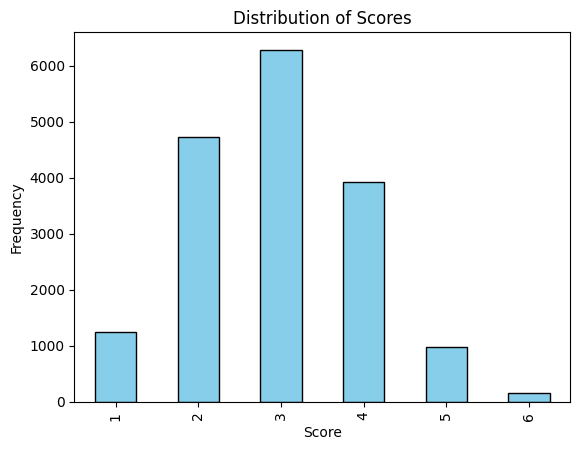

In [4]:
score_distribution = df['score'].value_counts().sort_index()

# Plot the distribution using a bar chart
score_distribution.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Preprocessing

# Using  DeBERTa

In [5]:
df.iloc[1,:]

essay_id                                               000fe60
full_text    I am a scientist at NASA that is discussing th...
score                                                        3
Name: 1, dtype: object

In [6]:
import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

2024-06-02 09:21:45.578327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 09:21:45.578427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 09:21:45.711481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [8]:
#score_tensor = tf.constant(df['score'].values)
essay_tensor = tf.constant(df['full_text'].values)

In [9]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [10]:
scores = [1, 3, 5, 2, 6]

labels_one_hot = to_ordinal( df['score'].values)

In [11]:
df['score'].values

array([3, 3, 4, ..., 2, 1, 2])

In [12]:
 labels_one_hot

array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       ...,
       [1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.]], dtype=float32)

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices((essay_tensor, labels_one_hot))

In [14]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

In [15]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


In [16]:
@tf.function
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [17]:
# dataset = dataset.map(preprocess_fn,num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
# dataset

In [19]:
# # Determine the total size and split ratios
# total_size = len(df['score'].values)
# train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
# test_size = total_size - train_size - val_size

# # Shuffle the dataset
# dataset = dataset.shuffle(buffer_size=500, reshuffle_each_iteration=False)

# # Split the dataset into training, validation, and test sets
# train_data = dataset.take(train_size)
# remaining_data = dataset.skip(train_size)
# val_data = remaining_data.take(val_size)
# test_data = remaining_data.skip(val_size)

In [20]:
# train_data

In [21]:
# train_data = train_data.batch(CFG.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# val_data = val_data.batch(CFG.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# test_data = test_data.batch(CFG.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)

In [23]:
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
       WeightedKappa()
    ],
)
model.summary()

Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 70,832,262 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
classifier.input

{'token_ids': <KerasTensor shape=(None, None), dtype=int32, sparse=None, name=token_ids>,
 'padding_mask': <KerasTensor shape=(None, None), dtype=int32, sparse=None, name=padding_mask>}

In [27]:
model.load_weights('/kaggle/input/automated-essay-scoring-2.0/other/essayscoring/1/model_checkpoint.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 406 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [28]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the file path for saving checkpoints
# checkpoint_path = '/kaggle/working/model_checkpoint.weights.h5'

# # Define the ModelCheckpoint callback
# checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                       monitor='val_loss',  # Save the model based on validation loss
#                                       save_weights_only=True,  # Save only the weights
#                                       save_best_only=False,  # Save only the best model
#                                       verbose=1)

In [29]:
# import math

# def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
#     lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
#     lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

#     def lrfn(epoch):  # Learning rate update function
#         if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
#         elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
#         elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
#         elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
#         elif mode == 'cos':
#             decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
#             phase = math.pi * decay_epoch_index / decay_total_epochs
#             lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
#         return lr

#     if plot:  # Plot lr curve if plot is True
#         plt.figure(figsize=(10, 5))
#         plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
#         plt.xlabel('epoch'); plt.ylabel('lr')
#         plt.title('LR Scheduler')
#         plt.show()

#     return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [30]:
# lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [31]:
# val_data

In [32]:
# history = model.fit(
#     train_data,
#     epochs=CFG.epochs,
#     validation_data=val_data,
#     callbacks=[lr_cb, checkpoint_callback]
# )

In [33]:
# best_epoch = np.argmax(model.history.history['val_weighted_kappa'])
# best_score = model.history.history['val_weighted_kappa'][best_epoch]
# best_loss = model.history.history['val_loss'][best_epoch]

# # Print and display best results
# print(f'\n{"=" * 17} RESULTS {"=" * 17}')
# print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Score : {best_score:.3f}\n>>>> BEST Epoch : {best_epoch}')
# print('=' * 50)

In [34]:
test_df  = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')

In [35]:
test_df

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [36]:
test_essay_tensor = tf.constant(test_df['full_text'].values)

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((test_essay_tensor,))

In [38]:
dataset = dataset.map(preprocess_fn,num_parallel_calls=tf.data.AUTOTUNE)

In [39]:
dataset = dataset.batch(CFG.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
test_pred = model.predict(dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1717320257.720877     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717320257.747694     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [41]:
test_pred

array([[9.9964392e-01, 9.3678981e-01, 4.9396461e-01, 3.7741356e-02,
        1.2370292e-03, 3.8501079e-04],
       [9.9983430e-01, 9.9399817e-01, 8.5885149e-01, 7.9025708e-02,
        1.0334861e-03, 2.3982402e-04],
       [9.9876571e-01, 9.9773610e-01, 9.9405956e-01, 9.2221504e-01,
        3.9723858e-01, 3.2722715e-02]], dtype=float32)

In [42]:
test_preds = np.sum((test_pred>0.5).astype(int), axis=-1)

In [43]:
test_preds = test_preds.clip(1,6)

In [44]:
df = pd.DataFrame({'essay_id': test_df['essay_id'].values, 'score': test_preds})

# Define the file name for the CSV
csv_file = "submission.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

In [45]:
df

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
